In [1]:
import yaml

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import plotly.express as px


from Toy_ML import training, inference, poly_fit
from plot_glodap import ArcticPlotter


In [2]:
with open("config.yaml", "r") as f:
    CONFIG = yaml.safe_load(f)

## 1. Pre-processing

### 1.1. Load the GloDAP data

In [3]:
# Name of columns
latitude_field = "Latitude [degrees North]"
longitude_field = "Longitude [degrees East]"
temperature_field = "TEMPERATURE [DEG C]"
salinity_field = "SALNTY [PSS-78]"
depth_field = "DEPTH [M]"
oxygen_iso_field = "O18/O16 [/MILLE]"
reference_field = "Sample ID:INTEGER"
dt_format = "yyyy-mm-ddThh:mm:ss.sss"


In [4]:
# --- Load CSV ---
df = pd.read_csv(CONFIG["glodap"])

# --- Clean data ---
# Replace missing or placeholder values (like '**') with NaN
df = df.replace("**", np.nan)
df = df.dropna(subset=[longitude_field, latitude_field, salinity_field, oxygen_iso_field,temperature_field])


In [5]:
# Convert columns to numeric if necessary
df[longitude_field] = pd.to_numeric(df[longitude_field])
df[latitude_field] = pd.to_numeric(df[latitude_field])
df[salinity_field] = pd.to_numeric(df[salinity_field])
df[oxygen_iso_field] = pd.to_numeric(df[oxygen_iso_field])

df["datetime"] = pd.to_datetime(df[dt_format])
df = df.drop(columns=dt_format)


#### 1.1.1. What does the data look like? 

First let us consider the spatial sampling of the data. 

We see that there is quite a spread across the Arctic region.
* In the 1980s, most of the data is confined to the ~0E
* In the late 2010s, the data is around the pole
* Between these dates, the data is more spread

In [6]:
# Call class
arcticplot = ArcticPlotter(df[latitude_field], df[longitude_field])

(<Figure size 800x800 with 2 Axes>,
 <GeoAxes: title={'center': 'Arctic Sampling Locations from GLODAP database'}>)

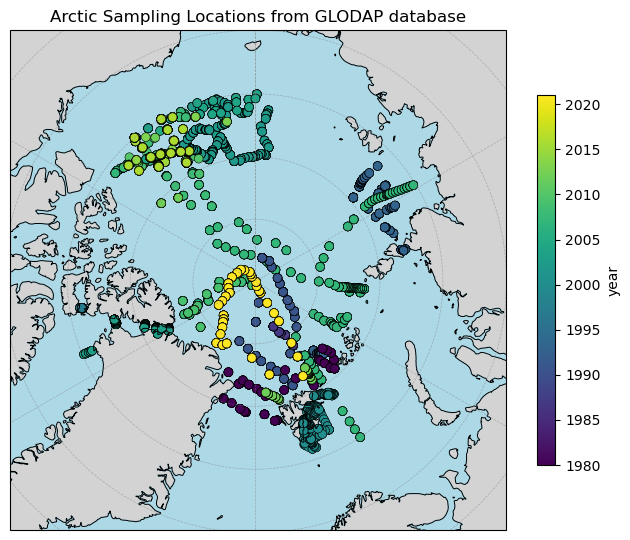

In [7]:
# Plot by year
arcticplot.plot(cbar_data=df["datetime"].dt.year)

A fundamental problem with this dataset is that there isn't enough data to be able to train the model on a regional basis, which we suggest will have a substantial influence on the oxygen isotopes. Unfortunately, there isn't a clear pattern in salinity, temperature or depth that would point to specific locations, as seen below

(<Figure size 800x800 with 2 Axes>,
 <GeoAxes: title={'center': 'Arctic Sampling Locations from GLODAP database'}>)

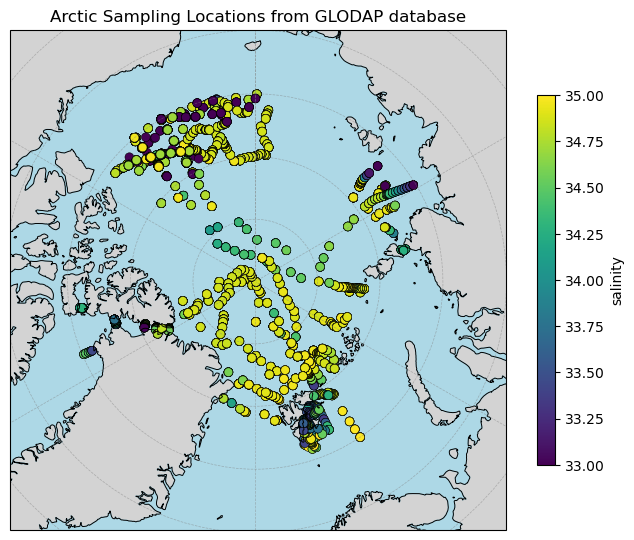

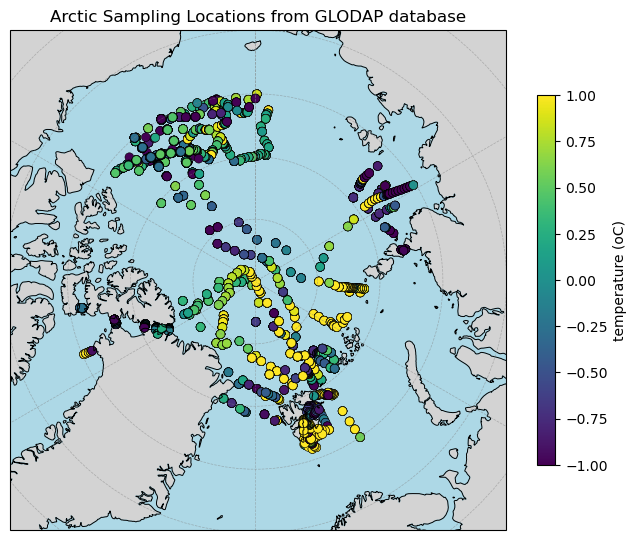

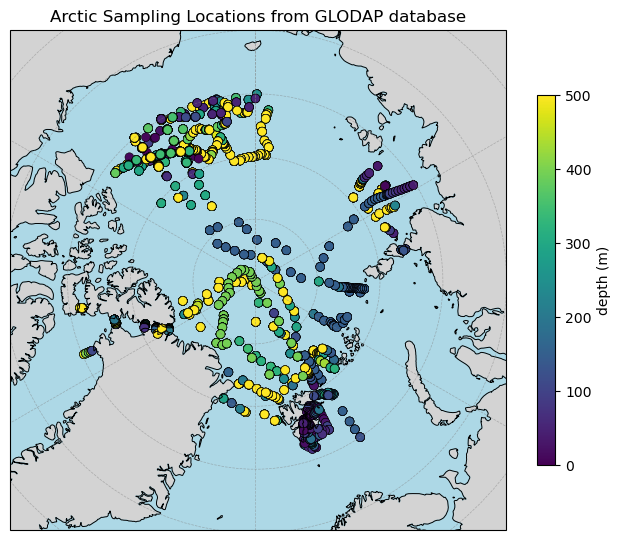

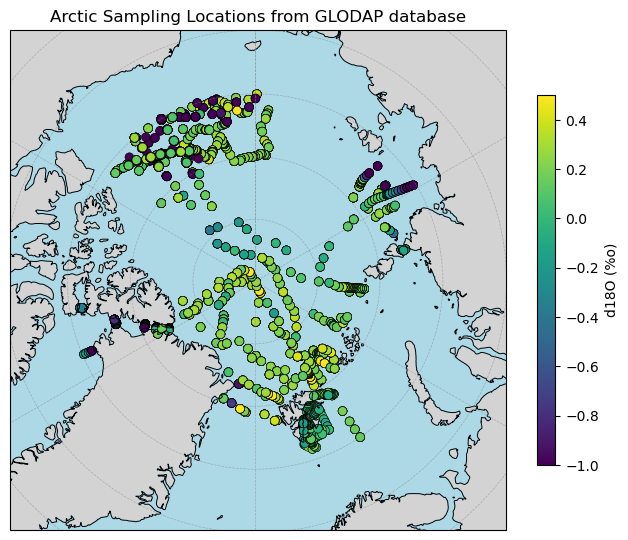

In [11]:
# Plot salinity over space
arcticplot.cbar_title = "salinity"
arcticplot.plot(cbar_data=df[salinity_field], vmin=33, vmax=35)

# Plot temperature over space
arcticplot.cbar_title = "temperature (oC)"
arcticplot.plot(cbar_data=df[temperature_field], vmin=-1, vmax=1)

# Plot depth over space
arcticplot.cbar_title = "depth (m)"
arcticplot.plot(cbar_data=df[depth_field], vmin=0, vmax=500)

# Plot oxygen isotope over space
arcticplot.cbar_title = "d18O (%o)"
arcticplot.plot(cbar_data=df[oxygen_iso_field], vmin=-1, vmax=0.5)


Now, let's consider the relationship between δ¹⁸O and temperature, salinity & depth. 

We can see that the strongest trend is in the salinity data. Temperature and depth are largely constant with δ¹⁸O except close to the origin (-2oC & 0m).

In [30]:
# --- Scatter plot: d18O vs. Salinity ---
fig_scatter = px.scatter(
    df,
    x=salinity_field,
    y=oxygen_iso_field,
    color=df["datetime"].dt.year,
    hover_data=[ latitude_field,longitude_field, reference_field],
    title="δ¹⁸O vs. Salinity from GLODAP database",
    # trendline="ols"  # optional: adds regression line
)
fig_scatter.update_layout(xaxis_title="Salinity", yaxis_title="δ¹⁸O (‰)")
fig_scatter.show()

# --- Scatter plot: d18O vs. Salinity ---
fig_scatter = px.scatter(
    df,
    x=temperature_field,
    y=oxygen_iso_field,
    color=df["datetime"].dt.year,
    hover_data=[ latitude_field,longitude_field, reference_field],
    title="δ¹⁸O vs. Temperature from GLODAP database",
    # trendline="ols"  # optional: adds regression line
)
fig_scatter.update_layout(xaxis_title="Temperature (oC)", yaxis_title="δ¹⁸O (‰)")
fig_scatter.show()

# --- Scatter plot: d18O vs. Depth ---
fig_scatter = px.scatter(
    df,
    x=depth_field,
    y=oxygen_iso_field,
    color=df["datetime"].dt.year,
    hover_data=[ latitude_field,longitude_field, reference_field],
    title="δ¹⁸O vs. Depth from GLODAP database",
    # trendline="ols"  # optional: adds regression line
)
fig_scatter.update_layout(xaxis_title="Depth (m)", yaxis_title="δ¹⁸O (‰)")
fig_scatter.show()

### 1.2. Seasonality & annual variation

Let's start by considering how many data points are in each month. We can see that the vast majority are in October & September, with very few in May and July.

In [31]:
# Count the number of observations in each month of a year
df["datetime"].dt.month.value_counts().sort_index()

datetime
5      228
7      249
8     3215
9     2423
10     795
Name: count, dtype: int64

To test this, we create a dataset that removes the summer months (May & July)

In [16]:
df_nosummer = df[~df['datetime'].dt.month.isin([5, 7])] # Drop summer months

## 2. Train the model

In [18]:
# Create the 90% for training & 10% for inference
df_10 = df_nosummer.sample(frac=0.10)  # 10% sample
df_90 = df_nosummer.drop(df_10.index)  # get rest

In [19]:
trained_model = training(df_90, 
                         [temperature_field, salinity_field, depth_field], 
                         oxygen_iso_field, 
                         create_plots=False
                         )

Epoch 0, Train Loss: 1.9826, Val Loss: 2.0075
Epoch 10, Train Loss: 1.3099, Val Loss: 1.2739
Epoch 20, Train Loss: 0.4554, Val Loss: 0.3761
Epoch 30, Train Loss: 0.2464, Val Loss: 0.2201
Epoch 40, Train Loss: 0.2013, Val Loss: 0.1758
Epoch 50, Train Loss: 0.1614, Val Loss: 0.1390
Epoch 60, Train Loss: 0.1472, Val Loss: 0.1234
Epoch 70, Train Loss: 0.1361, Val Loss: 0.1128
Epoch 80, Train Loss: 0.1285, Val Loss: 0.1044
Epoch 90, Train Loss: 0.1224, Val Loss: 0.0986
Epoch 100, Train Loss: 0.1174, Val Loss: 0.0934
Epoch 110, Train Loss: 0.1135, Val Loss: 0.0898
Epoch 120, Train Loss: 0.1104, Val Loss: 0.0871
Epoch 130, Train Loss: 0.1078, Val Loss: 0.0849
Epoch 140, Train Loss: 0.1056, Val Loss: 0.0831
Epoch 150, Train Loss: 0.1037, Val Loss: 0.0816
Epoch 160, Train Loss: 0.1021, Val Loss: 0.0803
Epoch 170, Train Loss: 0.1007, Val Loss: 0.0793
Epoch 180, Train Loss: 0.0996, Val Loss: 0.0784
Epoch 190, Train Loss: 0.0987, Val Loss: 0.0778
Epoch 200, Train Loss: 0.0978, Val Loss: 0.0771
Epo

In [20]:
model_test = inference(df_10, 
                       [temperature_field, salinity_field, depth_field],
                       oxygen_iso_field,
                       trained_model[1],
                       trained_model[0]
                       )

ML Predicted Oxygen RMSE: 0.26027009048804634
ML Predicted Oxygen R2: 0.9505863074939398
ML Predicted Oxygen Error Percentiles [0.0060167  0.03644321 0.0811635  0.19461051 0.5778915 ]


In [ ]:
model_test = inference(df_10, 
                       [temperature_field, salinity_field, depth_field],
                       oxygen_iso_field,
                       trained_model[1],
                       trained_model[0]
                       )

ML Predicted Oxygen RMSE: 0.3071666880731005
ML Predicted Oxygen R2: 0.929438393571168
ML Predicted Oxygen Error Percentiles [0.00671687 0.03844372 0.09077672 0.20590165 0.67877768]


In [15]:
poly_test = poly_fit(df_90, 
         df_10, 
         salinity_field,
         oxygen_iso_field,
         create_plot=False
         )

Poly Predicted Oxygen RMSE: 0.3852865801526486
Poly Predicted Oxygen R2: 0.8854448602259912
Poly Predicted Oxygen Error Percentiles [0.00940334 0.06027153 0.14367868 0.34979656 0.84442748]
